### Accessing MODIS data on Azure

[MODIS](https://modis.gsfc.nasa.gov/) provides Earth observation data in a wide spectral range, from 1999 to the present.  The MODIS satellites image the Earth every one to two days, though individual products derived from MODIS data may have lower temporal resolutions.  MODIS is administered by the [National Aeronautics and Space Administration](https://www.nasa.gov/) (NASA) and the [US Geological Survey](https://www.usgs.gov/) (USGS).

This dataset is stored in the East US Azure region, so this notebook will run most efficiently on Azure compute located in the same region.  If you are using this data for environmental science applications, consider applying for an [AI for Earth grant](http://aka.ms/ai4egrants) to support your compute requirements.

This notebook demonstrates access to MODIS surface reflectance data on Azure, but numerous other MODIS products are hosted on Azure and documented at [aka.ms/ai4edata-modis](http://aka.ms/ai4edata-modis).

### Environment setup

In [3]:
import os
import tempfile
import numpy as np
import shutil
import urllib
import matplotlib.pyplot as plt

import rasterio
from azure.storage.blob import ContainerClient

modis_account_name = 'modissa'
modis_container_name = 'modis-006'
modis_account_url = 'https://' + modis_account_name + '.blob.core.windows.net/'
modis_blob_root = modis_account_url + modis_container_name

# This file is provided by NASA; it indicates the lat/lon extents of each
# MODIS tile.
#
# The file originally comes from:
#
# https://modis-land.gsfc.nasa.gov/pdf/sn_bound_10deg.txt
modis_tile_extents_url = modis_blob_root + '/sn_bound_10deg.txt'

# Load this file into a table, where each row is (v,h,lonmin,lonmax,latmin,latmax)
modis_tile_extents = np.genfromtxt(modis_tile_extents_url,
                     skip_header = 7, 
                     skip_footer = 3)

modis_container_client = ContainerClient(account_url=modis_account_url, 
                                         container_name=modis_container_name,
                                         credential=None)

### Functions

In [1]:
def lat_lon_to_modis_tile(lat,lon):
    """
    Get the modis tile indices (h,v) for a given lat/lon
    
    https://www.earthdatascience.org/tutorials/convert-modis-tile-to-lat-lon/
    """
    
    found_matching_tile = False
    i = 0
    while(not found_matching_tile):
        found_matching_tile = lat >= modis_tile_extents[i, 4] \
        and lat <= modis_tile_extents[i, 5] \
        and lon >= modis_tile_extents[i, 2] and lon <= modis_tile_extents[i, 3]
        i += 1
        
    v = int(modis_tile_extents[i-1, 0])
    h = int(modis_tile_extents[i-1, 1])
    
    return h,v


def list_blobs_in_folder(container_name,folder_name):
    """
    List all blobs in a virtual folder in an Azure blob container
    """
    
    files = []
    generator = modis_container_client.list_blobs(name_starts_with=folder_name)
    for blob in generator:
        files.append(blob.name)
    return files
        
    
def list_tiff_blobs_in_folder(container_name,folder_name):
    """"
    List .tiff files in a folder
    """
    
    files = list_blobs_in_folder(container_name,folder_name)
    files = [fn for fn in files if fn.endswith('.tiff')]
    return files             

### Access and plot a MODIS tile


In [6]:
# Files are stored according to:
#
# http://modissa.blob.core.windows.net/modis-006/[product]/[htile]/[vtile]/[year][day]/filename

# This is the MODIS surface reflectance product
product = 'MCD43A4'

# Let's look at the tile containing Chicago, IL, on May 15, 2019 (day of year 135)
h,v = lat_lon_to_modis_tile(41.881832,-87.623177)
daynum = '2019135'
folder = product + '/' + '{:0>2d}/{:0>2d}'.format(h,v) + '/' + daynum

# Find all .tiff files from this tile on this day, one file per channel
files = list_tiff_blobs_in_folder(modis_container_name,folder)
print('Found {} matching files:\n'.format(len(files)))
for fn in files:
    print(fn)

Found 14 matching files:

MCD43A4/11/04/2019135/MCD43A4.A2019135.h11v04.006.2019149220457.hdf_01.tiff
MCD43A4/11/04/2019135/MCD43A4.A2019135.h11v04.006.2019149220457.hdf_02.tiff
MCD43A4/11/04/2019135/MCD43A4.A2019135.h11v04.006.2019149220457.hdf_03.tiff
MCD43A4/11/04/2019135/MCD43A4.A2019135.h11v04.006.2019149220457.hdf_04.tiff
MCD43A4/11/04/2019135/MCD43A4.A2019135.h11v04.006.2019149220457.hdf_05.tiff
MCD43A4/11/04/2019135/MCD43A4.A2019135.h11v04.006.2019149220457.hdf_06.tiff
MCD43A4/11/04/2019135/MCD43A4.A2019135.h11v04.006.2019149220457.hdf_07.tiff
MCD43A4/11/04/2019135/MCD43A4.A2019135.h11v04.006.2019149220457.hdf_08.tiff
MCD43A4/11/04/2019135/MCD43A4.A2019135.h11v04.006.2019149220457.hdf_09.tiff
MCD43A4/11/04/2019135/MCD43A4.A2019135.h11v04.006.2019149220457.hdf_10.tiff
MCD43A4/11/04/2019135/MCD43A4.A2019135.h11v04.006.2019149220457.hdf_11.tiff
MCD43A4/11/04/2019135/MCD43A4.A2019135.h11v04.006.2019149220457.hdf_12.tiff
MCD43A4/11/04/2019135/MCD43A4.A2019135.h11v04.006.201914922045

### Plot a composite image

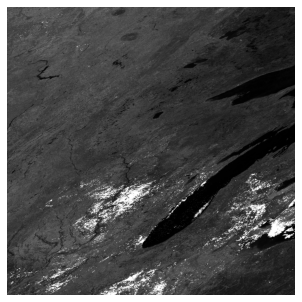

In [8]:
norm_value = 4000

# Channel 7 in an MCD43A4 HDF file corresponds to MODIS band 1.  
#
# Let's map bands 1, 4, and 3 (channels 7,10,9) to RGB.
channels = [7,10,9]
image_data = []
for ifn in channels:
    url = modis_blob_root + '/' + remote_fn
    with rasterio.open(url) as raster:
        band_array = raster.read(1)
        raster.close()
        band_array = band_array / norm_value
        image_data.append(band_array)

rgb = np.dstack((image_data[0],image_data[1],image_data[2]))
np.clip(rgb,0,1,rgb)
fig = plt.figure(frameon=False); ax = plt.Axes(fig,[0., 0., 1., 1.])
ax.set_axis_off(); fig.add_axes(ax)
plt.imshow(rgb);